In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
print(os.getcwd())

C:\Users\nesri\repos\projekt_dental


In [3]:
df = pd.read_excel("merged_df_25.08last.xlsx")

In [4]:
df.head()

,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
0,Belgium,2019,2 122.1,185.2,14.4,24.8,27.4,30.2,2 771.3,992,352,640
1,Rwanda,2019,3.5,0.3,2.0,21.2,31.4,40.0,20.1,99,32,67
2,Jordan,2019,74.7,7.4,7.3,13.8,38.5,42.8,120.1,97,37,60
3,Paraguay,2019,51.3,7.2,8.2,15.1,26.7,42.7,107.5,96,11,85
4,Kyrgyzstan,2019,3.9,0.6,10.3,11.7,35.0,47.9,26.5,93,26,67


| Sütun Adı                        | Açıklama                                                                 |
|----------------------------------|--------------------------------------------------------------------------|
| Location                         | Ülke adı (örneğin: Angola)                                               |                                          | Period                           | Veri yılı (örneğin: 2019)                                                |
| TotalExpenditure                 | Toplam harcama                                                           |
| PerCapitaExpenditure             | Kişi başına harcama                                                      |
| EdentulismRate                   | Dişsizlik oranı                                                          |
| PeriodontalRate                  | Periodontal hastalık oranı                                               |
| UntreatedCariesRate              | Tedavi edilmemiş çürük oranı                                             |
| UntreatedDeciduousCaries11_9Rate | Çocuklarda (1–9 yaş) çürük oranı                                         |
| ProductivityLossRate             | Üretkenlik Kaybı Oranı                                                   |
| both_cancer                      | Erkek + kadın kanser vakaları                                            |
| female_cancer                    | Kadın kanser vakaları                                                    |
| male_cancer                      | Erkek kanser vakaları                                                    |


In [5]:
# Tüm string sütunlarda boşlukları kaldır
df = df.apply(lambda col: col.str.replace(" ", "", regex=False) if col.dtype == "object" else col)

In [6]:
# Tekrarlayan satırları seç
duplicates = df[df.duplicated()]

# Kaç tane tekrar var
print(f"Toplam {duplicates.shape[0]} tekrarlayan satır var")


Toplam 0 tekrarlayan satır var


In [7]:
df.dtypes

Location                             object
Period                                int64
TotalExpenditure                     object
PerCapitaExpenditure                float64
EdentulismRate                      float64
PeriodontalRate                     float64
UntreatedCariesRate                 float64
UntreatedDeciduousCaries11_9Rate    float64
ProductivityLossRate                 object
both_cancer                          object
female_cancer                        object
male_cancer                          object
dtype: object

In [8]:
# Sayısal olması gereken sütunlar
cols_to_numeric = [
    "TotalExpenditure",
    "ProductivityLossRate",
    "both_cancer",
    "female_cancer",
    "male_cancer"
]

# Dönüştürme
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [9]:
df.dtypes

Location                             object
Period                                int64
TotalExpenditure                    float64
PerCapitaExpenditure                float64
EdentulismRate                      float64
PeriodontalRate                     float64
UntreatedCariesRate                 float64
UntreatedDeciduousCaries11_9Rate    float64
ProductivityLossRate                float64
both_cancer                         float64
female_cancer                       float64
male_cancer                         float64
dtype: object

In [10]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
53,Comoros,2019,0.3,0.3,2.9,22.8,32.3,40.3,2.7,5.0,NaN,5.0
54,Bahamas,2019,32.9,514.9,6.4,25.9,28.7,43.9,47.8,5.0,NaN,5.0
55,Maldives,2019,0.6,1.7,3.2,8.1,28.0,44.0,15.5,5.0,NaN,5.0


In [11]:
# Koşullu olarak NaN → 0
df.loc[df["female_cancer"].isna() & df["both_cancer"].notna(), "female_cancer"] = 0


In [12]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Period,192.0,2019.000000,0.000000,2019.0,2019.000,2019.00,2019.000,2019.0
TotalExpenditure,192.0,2016.106771,11135.195720,0.0,3.500,45.60,227.275,133505.8
PerCapitaExpenditure,192.0,54.919271,115.728152,0.0,0.675,9.20,39.525,867.2
EdentulismRate,192.0,7.644792,3.965027,1.2,4.300,7.50,10.625,16.8
PeriodontalRate,192.0,18.439583,6.910702,2.3,15.175,19.20,23.725,33.5
UntreatedCariesRate,192.0,32.256250,4.520687,21.9,29.200,31.85,35.500,49.5
UntreatedDeciduousCaries11_9Rate,192.0,41.733854,6.347399,18.7,39.075,43.60,46.500,53.2
ProductivityLossRate,192.0,1680.660417,7038.217347,0.1,21.950,103.65,744.250,78468.5
both_cancer,174.0,2124.356322,10860.615852,2.0,60.250,203.00,858.250,135929.0
female_cancer,174.0,646.954023,2673.235330,0.0,23.250,89.50,302.000,31268.0


In [14]:
# Eksik değerleri kontrol et
print(df.isna().sum())

Location                             0
Period                               0
TotalExpenditure                     0
PerCapitaExpenditure                 0
EdentulismRate                       0
PeriodontalRate                      0
UntreatedCariesRate                  0
UntreatedDeciduousCaries11_9Rate     0
ProductivityLossRate                 0
both_cancer                         18
female_cancer                       18
male_cancer                         18
dtype: int64


In [15]:
# 
# Kanser sütunları (both/female/male) -> NaN bırak
# Eksik değerleri 0 ile doldurmuyoruz, böylece analizde hatalı yorum olmaz


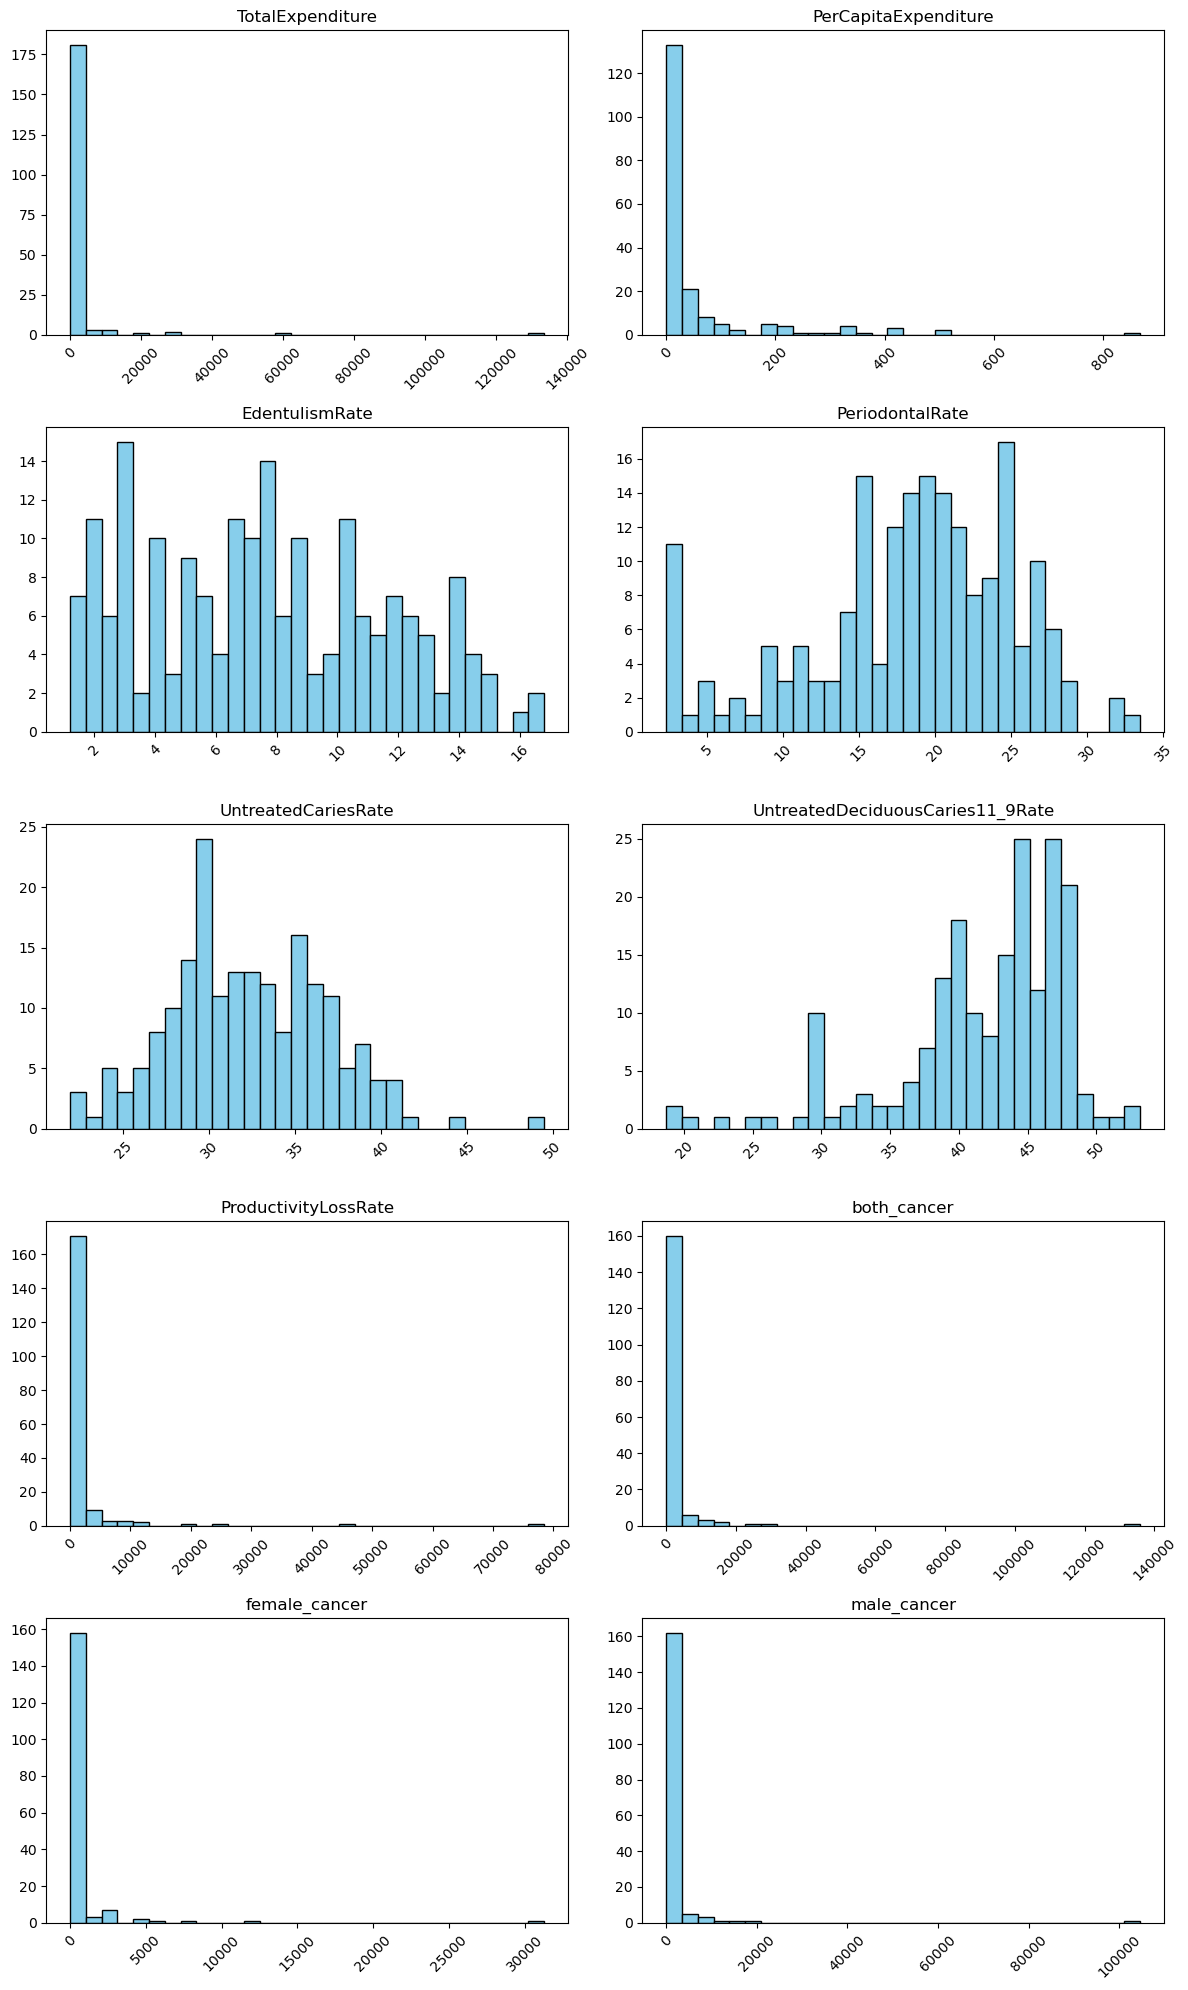

In [16]:
numeric_cols = [
    "TotalExpenditure",
    "PerCapitaExpenditure",
    "EdentulismRate",
    "PeriodontalRate",
    "UntreatedCariesRate",
    "UntreatedDeciduousCaries11_9Rate",
    "ProductivityLossRate",
    "both_cancer",
    "female_cancer",
    "male_cancer"
]

# 2 sütunlu subplot, satır sayısı otomatik
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols  # sütun sayısına göre satır sayısını ayarla

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Fazla boş subplotları gizle
if len(numeric_cols) % n_cols != 0:
    for j in range(len(numeric_cols), n_rows*n_cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [17]:
#En çok harcama yapan 10 ülke
top_total_expenditure = df.sort_values("TotalExpenditure", ascending=False).head(10)

print("En çok harcama yapan 10 ülke:")
print(top_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]].to_string(index=False))


En çok harcama yapan 10 ülke:
                                     Location  TotalExpenditure  PerCapitaExpenditure
                        UnitedStatesofAmerica          133505.8                 405.5
                                        China           61548.6                  44.0
                                      Germany           30877.3                 372.2
                                        Japan           28733.6                 227.7
                                        Italy           19123.0                 316.8
                                       Canada           12829.1                 342.5
                                       France           12666.0                 195.4
UnitedKingdomofGreatBritainandNorthernIreland            9576.9                 143.2
                                        Spain            8306.3                 178.0
                                    Australia            7370.3                 288.3


In [18]:
# En düşük harcama yapan 10 ülke
low_total_expenditure = df.sort_values("TotalExpenditure", ascending=True).head(10)
print("\nEn düşük harcama yapan 10 ülke:")
print(low_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]])


En düşük harcama yapan 10 ülke:
                     Location  TotalExpenditure  PerCapitaExpenditure
20                      Kenya               0.0                   0.0
48                   Cambodia               0.0                   0.0
97                       Iraq               0.0                   0.0
72                     Gambia               0.0                   0.0
106                    Bhutan               0.0                   0.1
128                     Niger               0.0                   0.0
60   UnitedRepublicofTanzania               0.1                   0.0
56                    Vanuatu               0.1                   0.5
174        SaoTomeandPrincipe               0.1                   0.6
168                  Ethiopia               0.1                   0.0


In [19]:

health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate","ProductivityLossRate"]

# Ülkeleri toplam harcama sırasına göre göster
df_top_spenders_health = top_total_expenditure[["Location"] + health_cols]
print("\nEn çok harcama yapan 10 ülkenin sağlık göstergeleri:")

# Tek satırda göstermek için
print(df_top_spenders_health.to_string(index=False))



En çok harcama yapan 10 ülkenin sağlık göstergeleri:
                                     Location  EdentulismRate  PeriodontalRate  UntreatedCariesRate  UntreatedDeciduousCaries11_9Rate  ProductivityLossRate
                        UnitedStatesofAmerica            10.2             15.7                 24.3                              42.6               78468.5
                                        China             5.7             17.5                 24.6                              47.2               45713.1
                                      Germany            11.7             27.4                 31.7                              29.1               19395.9
                                        Japan            11.7             20.6                 25.8                              39.5               23663.0
                                        Italy            12.9             18.2                 29.6                              36.1                9541.6
          

C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\831675181.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PerCapitaExpenditure", y="Location", data=top_total_expenditure, palette="viridis")


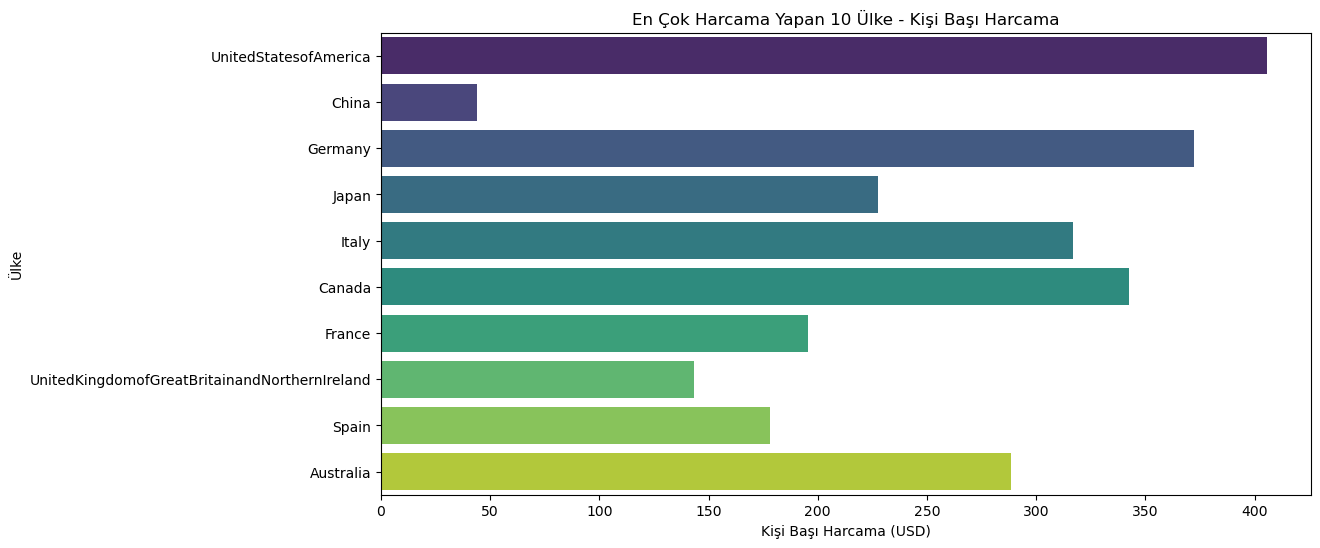

In [20]:

# Örnek: Top 10 ülke, kişi başı harcama
plt.figure(figsize=(12,6))
sns.barplot(x="PerCapitaExpenditure", y="Location", data=top_total_expenditure, palette="viridis")
plt.title("En Çok Harcama Yapan 10 Ülke - Kişi Başı Harcama")
plt.xlabel("Kişi Başı Harcama (USD)")
plt.ylabel("Ülke")
plt.show()


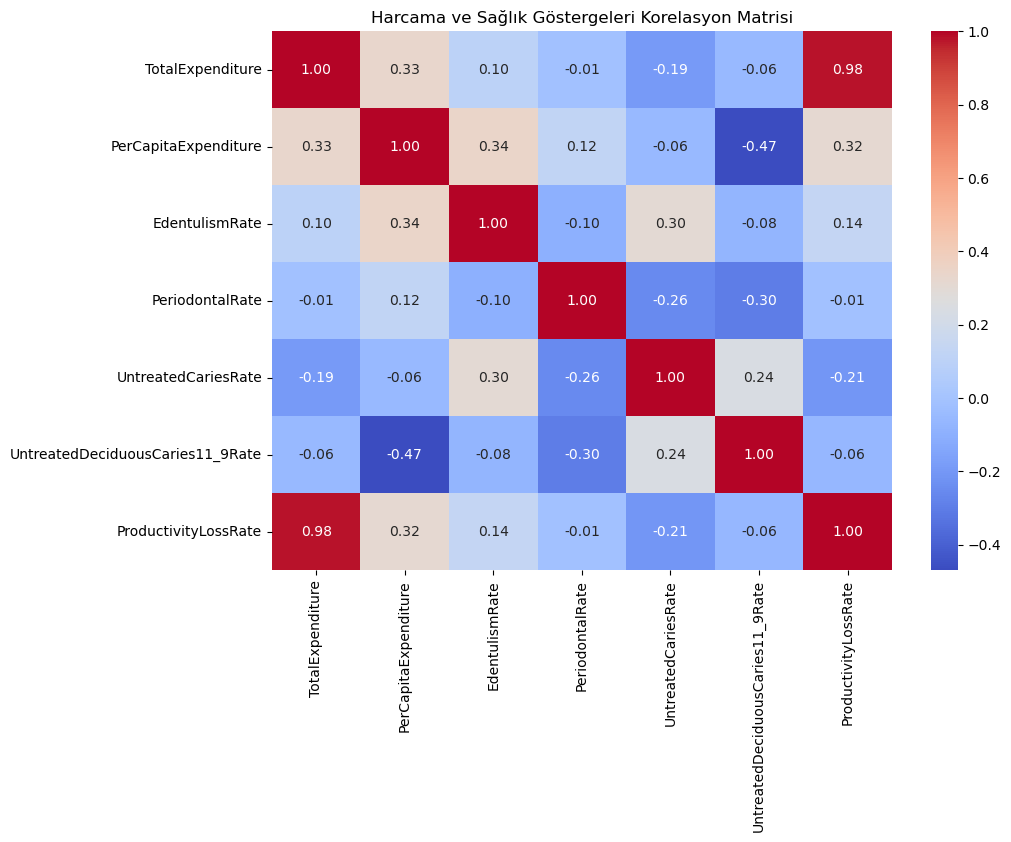

In [21]:
# Korelasyon için sayısal sütunlar
numeric_for_corr = ["TotalExpenditure", "PerCapitaExpenditure", 
                    "EdentulismRate", "PeriodontalRate", 
                    "UntreatedCariesRate", "UntreatedDeciduousCaries11_9Rate",
                    "ProductivityLossRate"]

# Korelasyon matrisi
corr = df[numeric_for_corr].corr()

# Heatmap ile görselleştirme
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Harcama ve Sağlık Göstergeleri Korelasyon Matrisi")
plt.show()


In [22]:
# TotalExpenditure'e göre 3 gruba ayır (Low, Medium, High)
df["ExpenditureGroup"] = pd.qcut(df["TotalExpenditure"], 3, labels=["Low", "Medium", "High"])

# Gruplara göre sağlık göstergelerinin ortalaması
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate"]

grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()
print("Harcama gruplarına göre sağlık göstergelerinin ortalaması:")
print(grouped_health)

Harcama gruplarına göre sağlık göstergelerinin ortalaması:
                  EdentulismRate  PeriodontalRate  UntreatedCariesRate  \
ExpenditureGroup                                                         
Low                     4.493750        18.701563            31.628125   
Medium                  8.445312        17.728125            32.607813   
High                    9.995313        18.889063            32.532812   

                  UntreatedDeciduousCaries11_9Rate  ProductivityLossRate  
ExpenditureGroup                                                          
Low                                      42.221875             37.326563  
Medium                                   43.009375            273.854688  
High                                     39.970312           4730.800000  


C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\950018395.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()


C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\2587328391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")


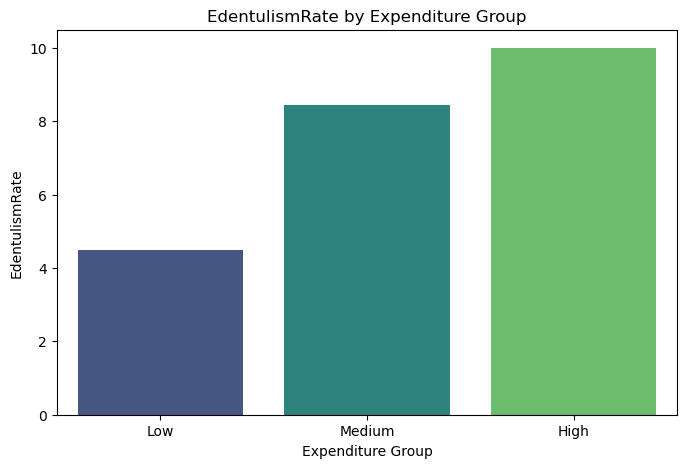

C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\2587328391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")


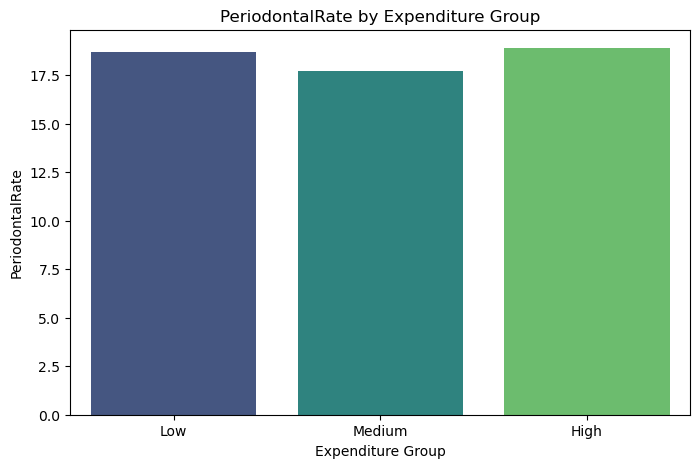

C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\2587328391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")


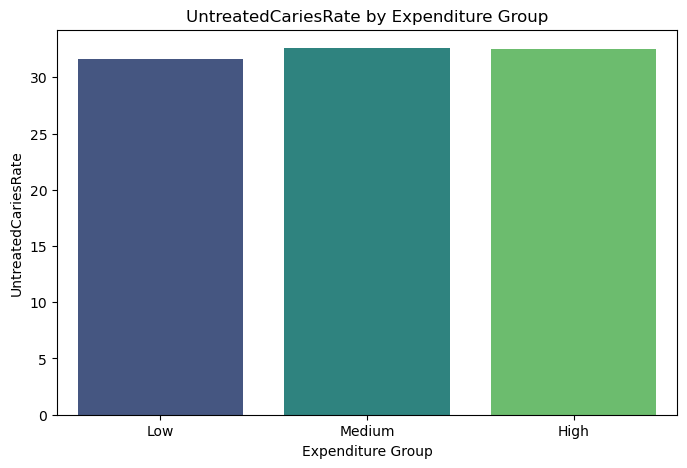

C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\2587328391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")


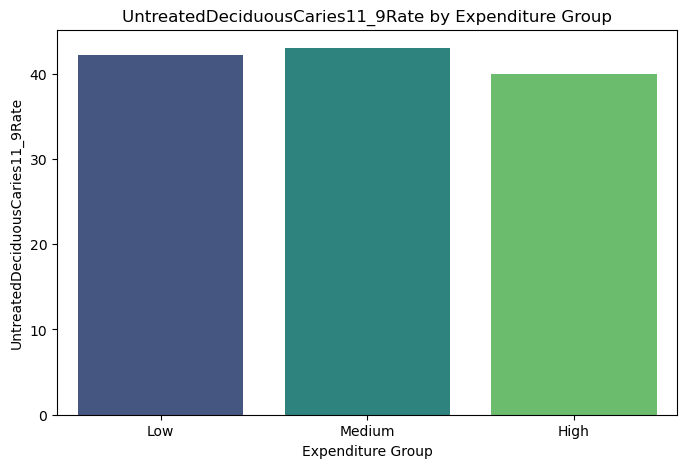

C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\2587328391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")


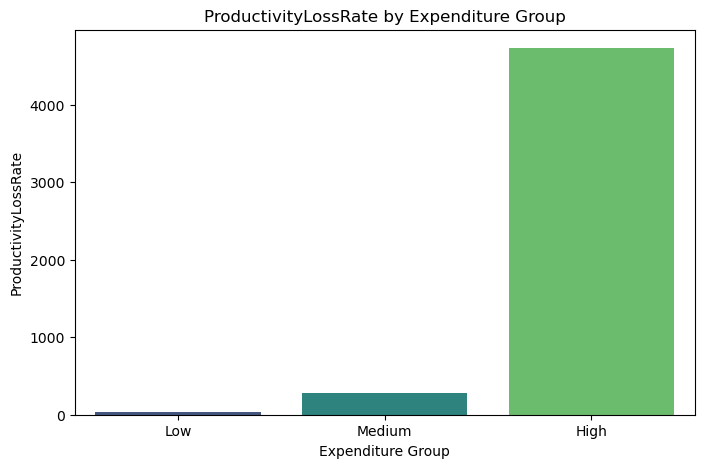

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Her sağlık göstergesi için gruplara göre barplot
for col in health_cols:
    plt.figure(figsize=(8,5))
    sns.barplot(x=grouped_health.index, y=grouped_health[col], palette="viridis")
    plt.title(f"{col} by Expenditure Group")
    plt.xlabel("Expenditure Group")
    plt.ylabel(col)
    plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\654117084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=top20_caries, palette="magma")


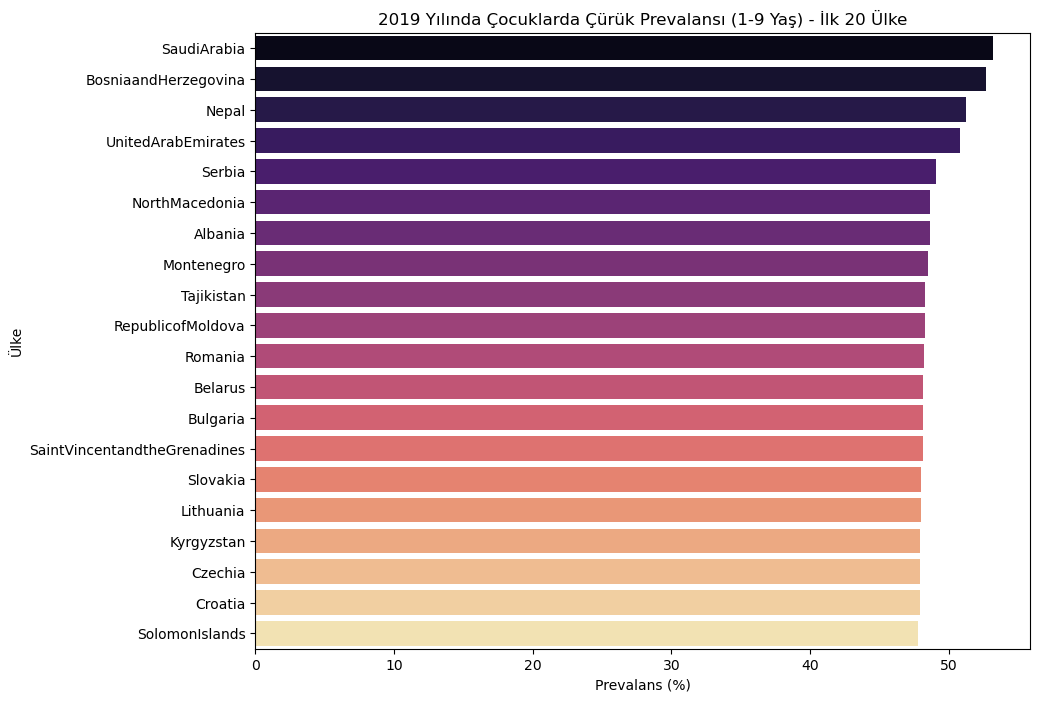

In [24]:
#2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke
# En yüksek 20 ülkeyi seç
top20_caries = df.nlargest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=top20_caries, palette="magma")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\592134809.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=bottom20_caries, palette="cool")


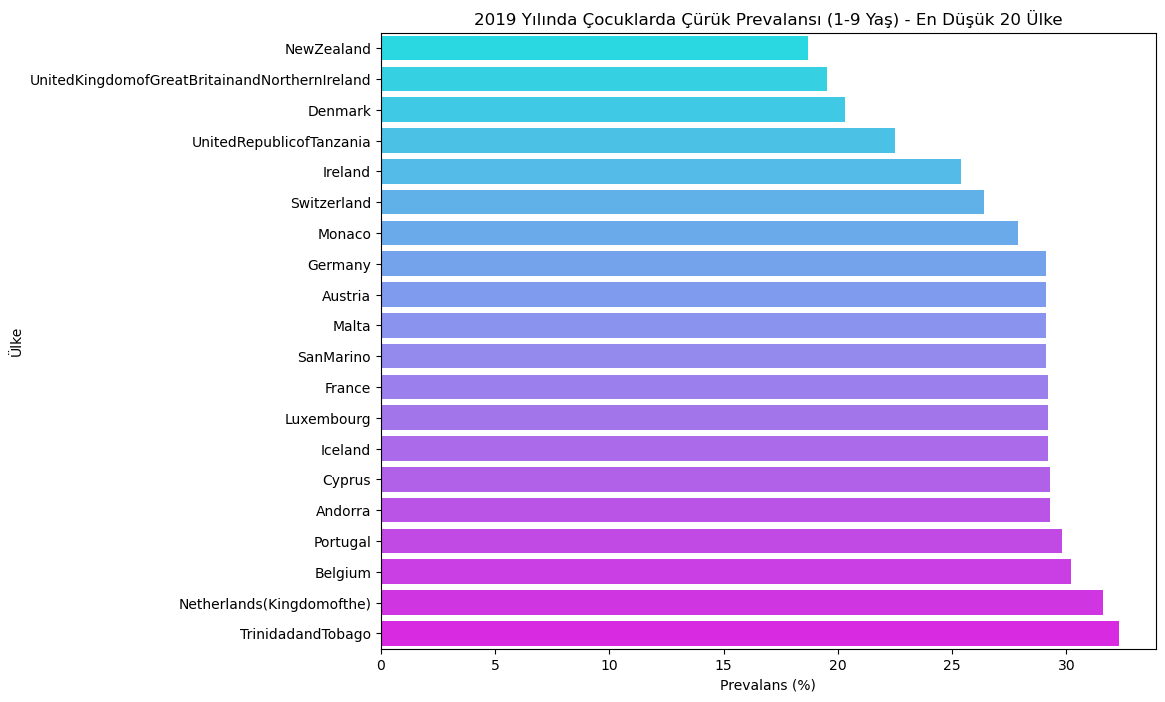

In [25]:
# En düşük 20 ülkeyi seç
bottom20_caries = df.nsmallest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=bottom20_caries, palette="cool")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - En Düşük 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


In [26]:
countries = ["Germany", "Türkiye"]
df_countries = df[df["Location"].isin(countries)]


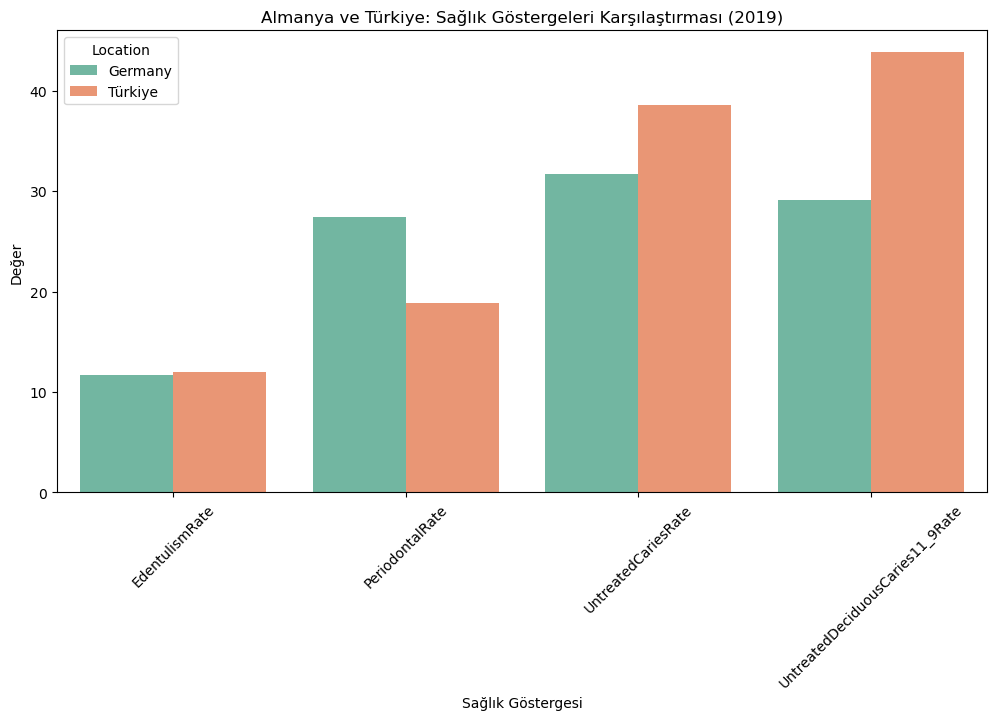

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate"]

plt.figure(figsize=(12,6))
df_melted = df_countries.melt(id_vars=["Location"], value_vars=health_cols,
                              var_name="HealthIndicator", value_name="Value")

sns.barplot(x="HealthIndicator", y="Value", hue="Location", data=df_melted, palette="Set2")
plt.title("Almanya ve Türkiye: Sağlık Göstergeleri Karşılaştırması (2019)")
plt.xlabel("Sağlık Göstergesi")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_35732\58164791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="both_cancer", y="Location", data=top20_cancer, palette="Reds")


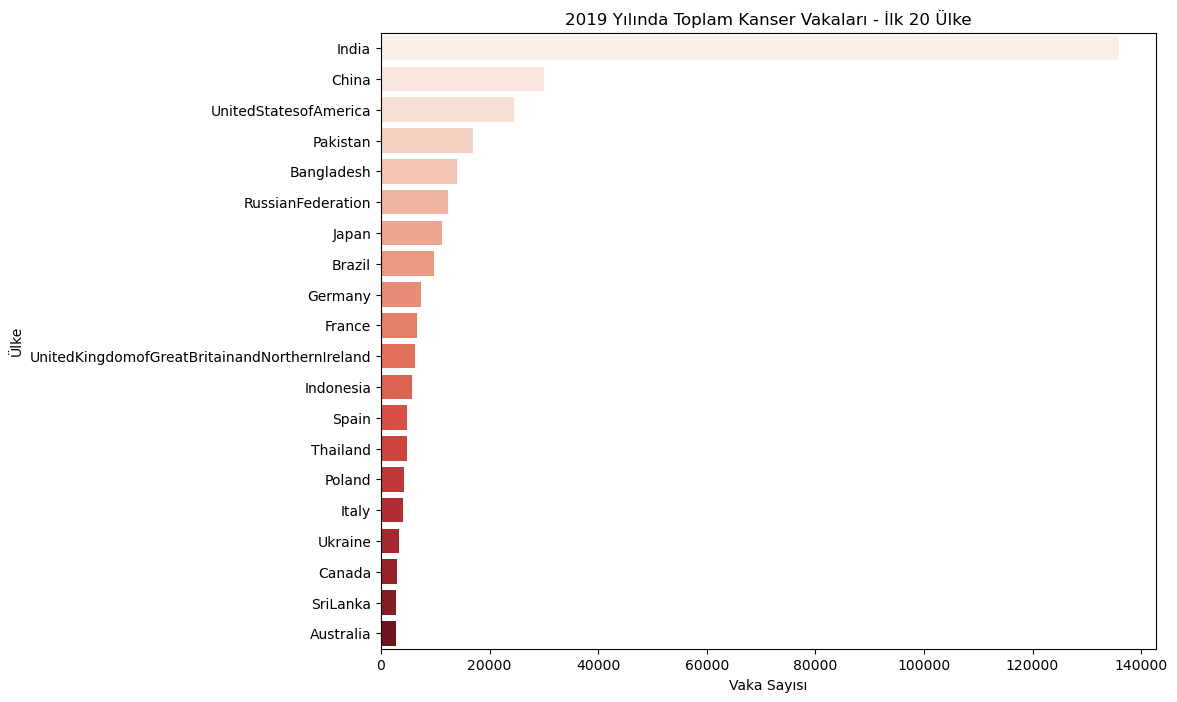

In [28]:
# Toplam kanser vaka sayısına göre ilk 20 ülke
top20_cancer = df.nlargest(20, "both_cancer")

plt.figure(figsize=(10,8))
sns.barplot(x="both_cancer", y="Location", data=top20_cancer, palette="Reds")
plt.title("2019 Yılında Toplam Kanser Vakaları - İlk 20 Ülke")
plt.xlabel("Vaka Sayısı")
plt.ylabel("Ülke")
plt.show()


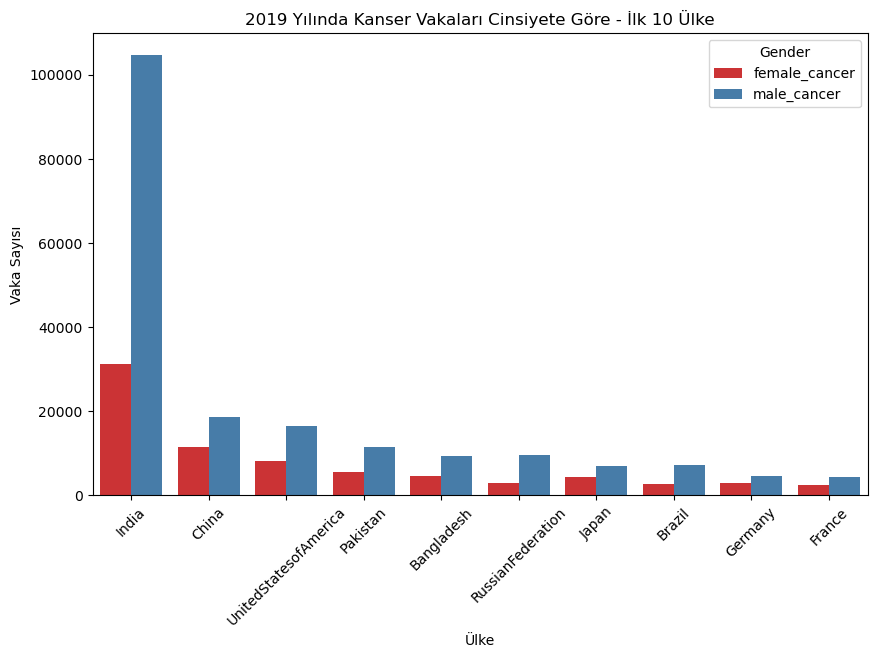

In [29]:
# Sadece ilk 10 ülke ile örnek
top10_cancer = df.nlargest(10, "both_cancer")
cancer_cols = ["female_cancer", "male_cancer"]

df_melted = top10_cancer.melt(id_vars=["Location"], value_vars=cancer_cols,
                               var_name="Gender", value_name="Cases")

plt.figure(figsize=(10,6))
sns.barplot(x="Location", y="Cases", hue="Gender", data=df_melted, palette="Set1")
plt.title("2019 Yılında Kanser Vakaları Cinsiyete Göre - İlk 10 Ülke")
plt.xlabel("Ülke")
plt.ylabel("Vaka Sayısı")
plt.xticks(rotation=45)
plt.show()


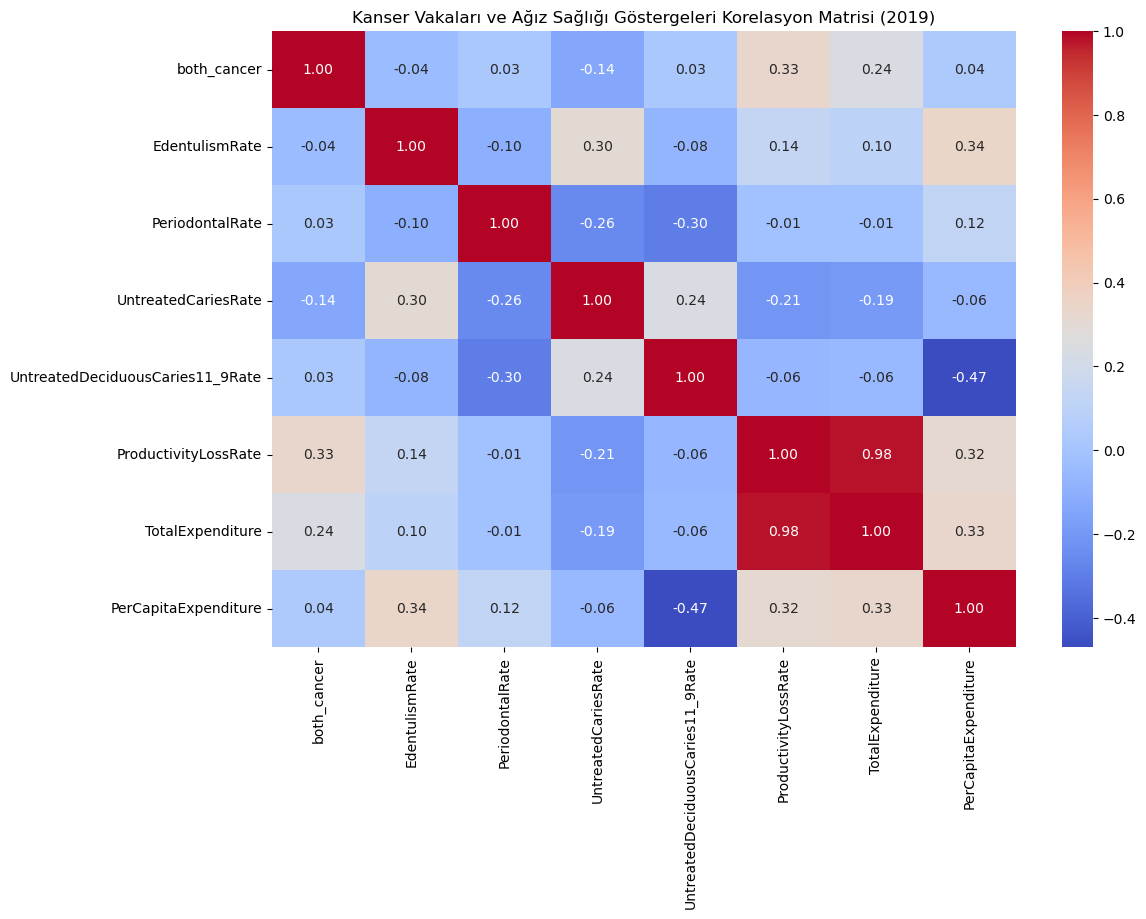

In [30]:
#Heatmap ile hem kanser ve ağız sağlığı hem de kanser ve harcama ilişkileri
corr_cols = ["both_cancer","EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
             "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate",
             "TotalExpenditure", "PerCapitaExpenditure"]

corr_df = df[corr_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Kanser Vakaları ve Ağız Sağlığı Göstergeleri Korelasyon Matrisi (2019)")
plt.show()


In [31]:
#Maschine Learning Önerileri

#1️⃣ Regresyon Modelleri

#Amaç: Sürekli değerleri tahmin etmek.

#Hedef değişken (target):

#ProductivityLossRate → ağız sağlığı ile üretkenlik kaybı arasındaki ilişkiyi tahmin et

#UntreatedDeciduousCaries11_9Rate → çocuklarda çürük prevalansını tahmin et

#Özellikler (features):

#TotalExpenditure, PerCapitaExpenditure

#EdentulismRate, PeriodontalRate, UntreatedCariesRate

#both_cancer, female_cancer, male_cancer

#Kullanılabilecek modeller: Linear Regression, Random Forest, XGBoost

#2️⃣ Sınıflandırma (Classification)

#Amaç: Ülkeleri gruplara ayırmak.

#Hedef değişken:

#Harcama seviyesine göre gruplama → Low / Medium / High

#Çürük prevalansına göre sınıflandırma → Düşük / Orta / Yüksek

#Özellikler: Diğer sağlık göstergeleri, kanser vakaları, kişi başı harcama vb.

#Kullanılabilecek modeller: Logistic Regression, Random Forest, XGBoost, SVM

#3️⃣ Kümeleme (Clustering)

#Amaç: Benzer ülkeleri otomatik gruplama.

#Özellikler: Tüm sayısal göstergeler (TotalExpenditure, PerCapitaExpenditure, sağlık göstergeleri, kanser vakaları vb.)

#Kullanılacak yöntemler:

#K-Means → ülkeleri sayısal özelliklerine göre k gruba ayırır

#Hierarchical Clustering → hiyerarşik benzerlik analizi

#Görselleştirme: PCA ile 2D projeksiyon, renkler = kümeler

#4️⃣ Feature Importance Analizi

#Hangi değişkenler çocuklarda çürük, ProductivityLossRate veya kanser vakalarını en çok etkiliyor?

#Random Forest veya XGBoost kullanarak feature importance çıkarabiliriz.

#5️⃣ Örnek Pipeline

#Veriyi temizle → eksik değerleri doldur, aykırı değerleri cap’le

#Sayısal sütunları normalize / standardize et

#Hedef değişkeni seç ve features ile ayır

#Train-test split yap (örn. 80-20)

#Model seç ve eğit

#Model performansını değerlendir: RMSE, MAE (regresyon) veya Accuracy, F1-score (sınıflandırma)

#💡 Özetle:

#Regresyon → üretkenlik kaybı veya çürük oranı tahmini

#Sınıflandırma → ülkeleri sağlık veya harcama kategorilerine ayırma

#Kümeleme → benzer ülkeleri segmentleme